In [ ]:
reset -fs

In [2]:
from Brainmets.utils import *
from Brainmets.dataset import *
from Brainmets.augmentations import Transformer
from Brainmets.losses import *
from Brainmets.trainer import *
from Brainmets.evaluation import *

In [3]:
name = 'Baseline'
loss = 'Diceloss'
suffix = 'example2'
name = '-'.join([name, loss, suffix])
gpu = '1'
debug = 'True'

debug_size = 20
init_lr = 0.001
max_lr = 0.001
final_div_factor = 100
epochs = 2
print_per_instance = True
use_one_cycle = True

device = torch.device('cuda:' + gpu)


In [4]:
data_path = Path('/home/chens/practicum/MEDomicsLab-develop-brainmets/model_training/3_unet_3d_residual/data/')
data = 'manuscript_1_datasets_first_tx_allmets'
df = pd.read_csv(data_path/f'{data}.csv')

In [5]:
train_df = df[df['split']=='train'].sample(frac=1)
valid_df = df[df['split']=='valid'].sample(frac=1)
test_df = df[df['split']=='test'].sample(frac=1)

train_img_files = list(train_df['img_files'])
train_mask_files = list(train_df['mask_files'])
valid_img_files = list(valid_df['img_files'])
valid_mask_files = list(valid_df['mask_files'])
test_img_files = list(test_df['img_files'])
test_mask_files = list(test_df['mask_files'])

img_files = sorted(train_img_files+valid_img_files+test_img_files)
mask_files = sorted(train_mask_files+valid_mask_files+test_mask_files)
img_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in img_files]
mask_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in mask_files]
assert img_names==mask_names

In [6]:
# train_transformer = Transformer(axes=['d', 'h', 'w'], max_zoom_rate=1.5, angle=15)
train_transformer = None
valid_transformer = None
test_transformer = None

if debug == 'True':
    train_dataset = MetDataSet(
        train_df.iloc[:debug_size], train_transformer)
    valid_dataset = MetDataSet(valid_df.iloc[:debug_size])
    test_dataset = MetDataSet(test_df.iloc[:debug_size])
else:
    train_dataset = MetDataSet(train_df, train_transformer)
    valid_dataset = MetDataSet(valid_df)
    test_dataset = MetDataSet(test_df)

In [7]:
print('train data size: ', len(train_dataset))
print('valid data size: ', len(valid_dataset))
print('test data size: ', len(test_dataset))

train data size:  20
valid data size:  20
test data size:  20


In [151]:
img = np.load(train_img_files[0])
mask = np.load(train_mask_files[0])

In [152]:
norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)

In [153]:
# Single case test
# pair = train_dataset[4]
# img, mask = pair[0][0], pair[1][0]

In [154]:
# Show Single Slice
# show_single_pair(img, mask, 40)

In [168]:
img = Image.fromarray(norm_image[35])

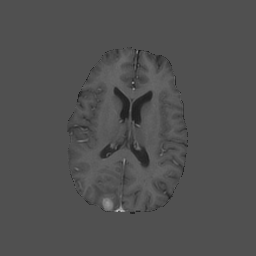

In [169]:
img

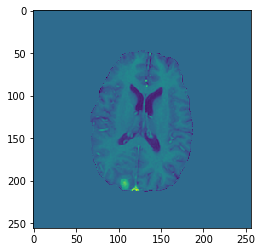

In [149]:
plt.imshow(norm_image[35])

In [92]:
# Show Single Image
# show_single_image(norm_image, mask)

In [158]:
from histogram_equalization.contrast import ImageContraster

In [159]:
icter = ImageContraster()

In [163]:
clahe_eq_img = icter.enhance_contrast(img, method = "CLAHE", blocks = 8, threshold = 10.0)
he_eq_img = icter.enhance_contrast(img, method = "HE")
lrs_eq_img = icter.enhance_contrast(img, method = "Bright")
ahe_eq_img = icter.enhance_contrast(img, method = "AHE", window_size = 32, affect_size = 16)
# icter.plot_images(img, clahe_eq_img)

/home/chens/anaconda3/envs/schen/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chens/anaconda3/envs/schen/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chens/practicum/MEDomicsLab-develop-brainmets/model_training/3_unet_3d_residual/Brainmets/histogram_equalization/contrast.py:232: RuntimeWarning: invalid value encountered in long_scalars
  hists_cdf = (max_v - min_v) / hists_cumsum[-1] * hists_cumsum + min_v


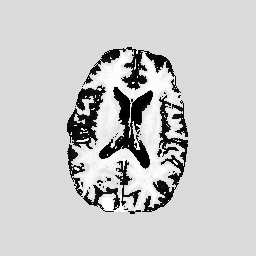

In [161]:
he_eq_img

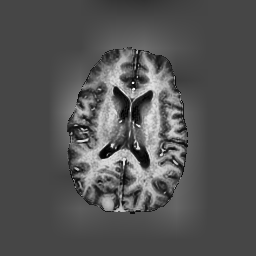

In [162]:
clahe_eq_img

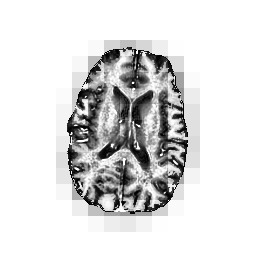

In [164]:
ahe_eq_img

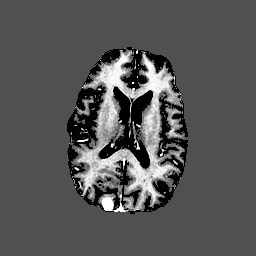

In [165]:
lrs_eq_img

In [124]:
clahe_eq_img = np.array(clahe_eq_img)

In [11]:
# Show All Images
# show_all_images(train_dataset)

In [12]:
if loss == 'Diceloss':
    loss_func = DiceLoss().to(device)
elif loss == 'BCE':
    loss_config = {'name': 'BCEWithLogitsLoss'}
    config = {'loss': loss_config}
    loss_func = get_loss_criterion(config).to(device)
elif loss == 'BCE_my':
    loss_func = FocalLossLogits().to(device)
elif loss == 'Focal':
    loss_func = FocalLossLogits(pos_weight=1, gamma=0.5).to(device)
elif loss == 'WBCE_my':
    loss_func = FocalLossLogits(pos_weight=2).to(device)
elif loss == 'WBCE':
    pos_weights = torch.tensor(2)
    loss_config = {
        'name': 'WeightedBCEWithLogitsLoss',
        'pos_weight': pos_weights}
    config = {'loss': loss_config}
    loss_func = get_loss_criterion(config).to(device)


In [13]:
trainer = Trainer(
    name,
    'ResidualUNet3D',
    train_dataset,
    valid_dataset,
    test_dataset,
    1,
    init_lr,
    max_lr,
    loss_func,
    device)

[16, 32, 64, 128, 256, 512]
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [14]:
x, y = ntrain_settrainer.train_loader))

In [ ]:
pred = trainer.model(x.to(device))

In [ ]:
trainer.fit(epochs,print_per_instance,use_one_cycle)

In [11]:
trainer = Trainer.load_best_checkpoint(name)

best_epoch:  35


In [12]:
test_score = trainer.predict()

100%|██████████| 110/110 [01:15<00:00,  1.46it/s]

test_score: 0.7872632243416526


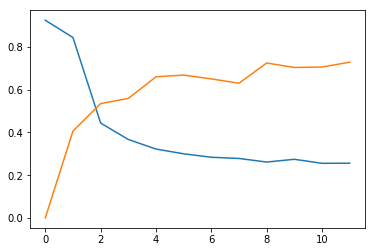

In [21]:
plt.plot(trainer.train_losses)
plt.plot(trainer.valid_scores)

In [ ]:
XX